## QSOs by Band (Great Circle)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import colorsys
import datetime as dt
import maidenhead as mh
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sqlite3

In [2]:
# Covert X,Y coordinates in the plot space to LON,LAT
def cartesian_to_userland(x_cart, y_cart, ax):
    x, y = ax.projection.transform_point(x_cart, y_cart, ccrs.PlateCarree())
    return x, y

In [3]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [4]:
# Load QSO data directly from MacLoggerDX SQLite database

dbfile = '/Users/mhb/Documents/MLDX_Logs/MacLoggerDX.sql'
connstr = 'file:{}?mode=ro'.format(dbfile)
con = sqlite3.connect(connstr, uri=True)

# Get field names
rows = con.execute("PRAGMA table_info(qso_table_v007)").fetchall()
fields = [rec[1] for rec in rows]
#print(fields)

# Get log data
rows = con.execute("select * from qso_table_v007").fetchall()
con.close()

# Put log data into a data frame
qso_df = pd.DataFrame(rows, columns=fields)

# Keep only the 4-character grid square portion
qso_df['grid'] = qso_df.grid.astype(str).str.slice(0,4)

# Lower-casify the band_rx column
qso_df['band_rx'] = qso_df['band_rx'].str.lower()

# Generate a date string from the qso_start column
qso_df['qsodate'] = qso_df['qso_start'].apply(lambda x: dt.datetime.utcfromtimestamp(x).strftime('%Y%m%d%H%M'))

print('Loaded {} QSOs and {} distinct grid squares.'.format(
    len(qso_df),
    qso_df['grid'].nunique()
))

Loaded 1413 QSOs and 684 distinct grid squares.


In [5]:
# Filter the QSO data frame by date/time
from_str = '2022-09-12 04:00'
to_str   = '2022-09-19 04:00'

# Don't change anything here
from_dt = dt.datetime.strptime(from_str, '%Y-%m-%d %H:%M')
to_dt   = dt.datetime.strptime(to_str,   '%Y-%m-%d %H:%M')

# Format for the map description
from_ts = from_dt.strftime('%Y%m%d%H%M%S')
to_ts = to_dt.strftime('%Y%m%d%H%M%S')

# Make a copy of the original QSO data
qso_df2 = qso_df.copy(deep=True)

# Filter by date
qso_df2 = qso_df2[(qso_df2['qsodate']>=from_ts) & (qso_df2['qsodate']<=to_ts)]
qso_df2.shape

(59, 50)

In [6]:
# Convert grid square location to latitude and longitude (center of grid square)
qso_df2[['grlat', 'grlon']] = qso_df2['grid'].apply(lambda g: mh.to_location(g, center=True)).tolist()

# Jitter the coordinates
qso_df2['grlat'] = qso_df2['grlat'] + np.random.rand(len(qso_df2)) - 0.5
qso_df2['grlon'] = qso_df2['grlon'] + np.random.rand(len(qso_df2)) - 0.5

# Get a list of distinct bands, sorted
bands = qso_df2['band_rx'].unique().tolist()
bands.sort(key=lambda b: int(b[0:len(b)-1]))
print(bands)

# Generate a color map based on the number of distinct bands
my_colormap = plt.cm.get_cmap('jet', len(bands))
colors = [lighten_color(my_colormap(x), 0.5) for x in np.arange(0, 1, 1/len(bands))]
band_color = {}
for x in range(len(bands)):
    band_color[bands[x]] = colors[x]

['10m', '12m', '15m', '20m', '40m']


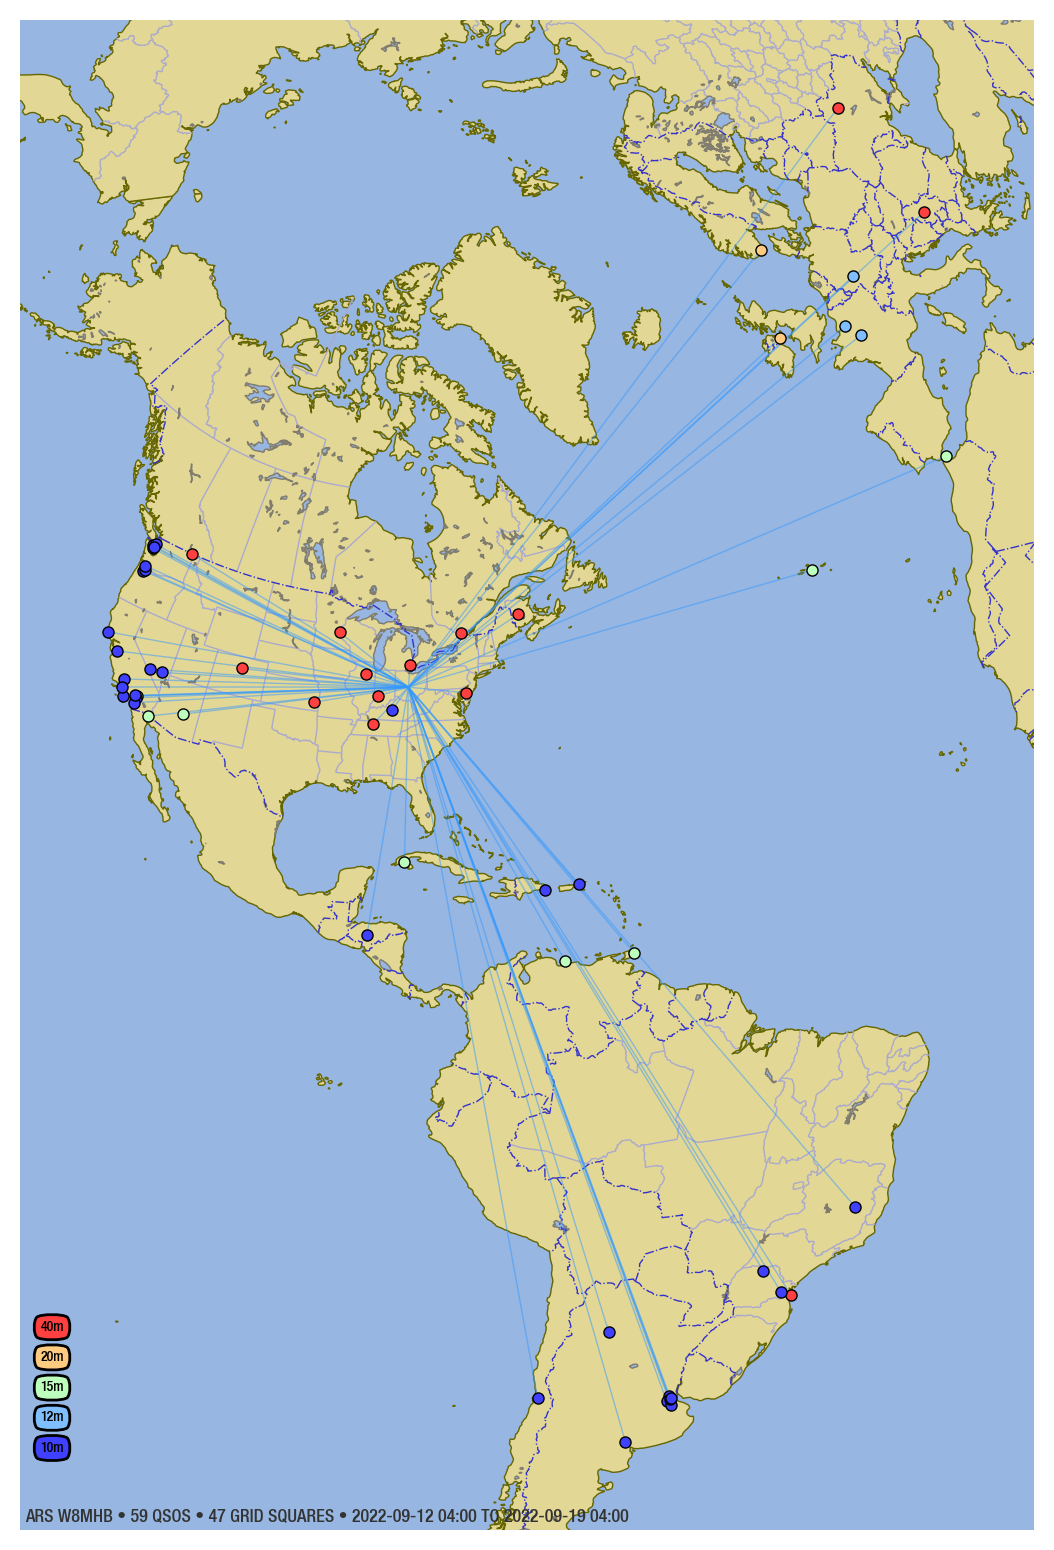

In [7]:
# Compute plot coords of my home location
lat_0, lon_0 = mh.to_location('EN80lb', center=True)

# Initialize figure
fig = plt.figure(figsize=(10,10), dpi=200)
fig.tight_layout(pad=0)
proj = ccrs.AzimuthalEquidistant(central_longitude=lon_0, central_latitude=lat_0)
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Omit the border
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)

# Compute dates - <d> days ago (from above) to today
#new_start = (dt.datetime.today() - dt.timedelta(days=d-1)).strftime('%Y.%m.%d')
#new_end = dt.datetime.today().strftime('%Y.%m.%d')

# Load the raster image
#fname = "/Users/mhb/_Jupyter Notebooks/Grid Maps/eo_base_2020_clean_geo.png"
#img = plt.imread(fname)
#img = img[::-1]
#ax.imshow(img, origin='lower', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])

# Add map features

# Add Ocean
ax.add_feature(
    cfeature.NaturalEarthFeature(category='physical',scale='50m',name='ocean'),
    facecolor='#97B6E1',
    edgecolor='#000000',
    linewidth=0
)

# Add Land
ax.add_feature(
    cfeature.NaturalEarthFeature(category='physical',scale='50m',name='land'),
    facecolor='#E3D796',
    edgecolor='#666600',
    linewidth=0.5
)

# Add States
ax.add_feature(
    cfeature.NaturalEarthFeature(category='cultural',scale='50m',name='admin_1_states_provinces_lines'),
    facecolor='none',
    edgecolor='#AAAACC',
    linewidth=0.5
)

# Add Lakes
ax.add_feature(
    cfeature.NaturalEarthFeature(category='physical',scale='50m',name='lakes'),
    facecolor='#97B6E1',
    edgecolor='#807C6E',
    linewidth=0.5
)

# Add Boundary Lines
ax.add_feature(
    cfeature.NaturalEarthFeature(category='cultural',scale='50m',name='admin_0_boundary_lines_land'),
    facecolor='none',
    edgecolor='#3333CC',
    linewidth=0.5,
    linestyle='-.'
)

# Font setup
font = {
    'family': 'Menlo',
    'color':  '#333333',
    'weight': 'medium',
    'size': 5,
    'alpha': 1.0
}

# Compute map extremes
llx = qso_df2.apply(lambda x: cartesian_to_userland(x.grlon, x.grlat, ax)[0], axis=1).min()
lly = qso_df2.apply(lambda x: cartesian_to_userland(x.grlon, x.grlat, ax)[1], axis=1).min()
urx = qso_df2.apply(lambda x: cartesian_to_userland(x.grlon, x.grlat, ax)[0], axis=1).max()
ury = qso_df2.apply(lambda x: cartesian_to_userland(x.grlon, x.grlat, ax)[1], axis=1).max()

# Iterate over the records
for row in qso_df2.iterrows():
    rec = row[1]
    
    # Plot line from HOME to grid square
    ax.plot(
        [lon_0, rec.grlon], [lat_0, rec.grlat],
        color='#3399FF80', marker='None', ls='-', lw=0.5, transform=ccrs.Geodetic(),
        zorder=10
    )

    # Plot grid squares (as dots)
    ax.plot(
        [rec.grlon], [rec.grlat],
        color=band_color[rec['band_rx']], marker='o', mec='#000000', mew=0.5, ms=4.0, transform=ccrs.Geodetic(),
        zorder=30
    )

# Add a description in the lower left
num_qsos = len(qso_df2)
num_grids = qso_df2['grid'].nunique()
message = 'ARS W8MHB • {} QSOS • {} GRID SQUARES • {} TO {}'.format(
    num_qsos, num_grids, from_str, to_str)
ax.annotate(
    message, xy=(0., 0.), xycoords='axes fraction', color='#333333',
    #backgroundcolor='white',
    fontfamily='Helvetica Neue LT Std', fontstretch='condensed', fontweight='medium', fontsize=6.5,
    xytext=(2, 2), textcoords='offset points',
    ha='left', va='bottom', zorder=300)

# Crop the image
p = 1000000
ax.set_xlim([llx-p, urx+p])
ax.set_ylim([lly-p, ury+p])

# Add key
bn = 0
for b in band_color.keys():
    ax.annotate(
        b, xy=(0.02, 0.05+0.02*bn), xycoords='axes fraction',
        color='#000000',
        #backgroundcolor=band_color[b],
        fontfamily='Helvetica Neue LT Std', fontstretch='condensed', fontweight='medium', fontsize=5,
        bbox=dict(boxstyle='round4,pad=.5', fc=band_color[b], ec='#000000'),
        #xytext=(2, 2), textcoords='offset points',
        ha='left', va='bottom', zorder=300)
    bn = bn + 1

#fn = '/Users/mhb/OneDrive/hamradio/maps/Grid Maps/qsos-temp.jpg'
#fig.savefig(fn, bbox_inches='tight', pad_inches=0)